# Imports

In [117]:
import os, os.path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imageio
from glob import glob
from utils import *
import cv2
from scipy.ndimage import convolve
from mpl_toolkits.axes_grid1 import make_axes_locatable

import time

In [70]:
!pwd

/Users/tiffanyshih/Documents/Coursework/MIDS_281/Final_Project


# Set Up Files and File Names

In [ ]:
# Get All EO and SAR File Names
start_time = time.time()

rootdir = './train_images'
# labels = [i for i in range(10)]

# Initialize filename lists
eo_filenames = []
sar_filenames = []

# Loop through all folder or labels
for i in range(10):
    path = rootdir + "/" + str(i)
    print(path)
    # for name in os.listdir(path):
    #     if os.path.isfile(os.path.join(path, name)) and name.startswith("EO"):
    #         eo_filenames[i].append(name)
    eo_filenames.append([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name)) and name.startswith("EO")])
    sar_filenames.append([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name)) and name.startswith("SAR")])
    
end_time = time.time()
print("Time to run cell:", end_time - start_time)

In [27]:
# Sort filenames of EO and SAR images so we can access them through the same index
for i in range(10):
    eo_filenames[i].sort()
    sar_filenames[i].sort()


In [28]:
# Check if they are sorted
print(eo_filenames[3][:10])
print(sar_filenames[3][:10])

['EO_100040.png', 'EO_100043.png', 'EO_100123.png', 'EO_100126.png', 'EO_100159.png', 'EO_100164.png', 'EO_100178.png', 'EO_100203.png', 'EO_100225.png', 'EO_100270.png']
['SAR_100040.png', 'SAR_100043.png', 'SAR_100123.png', 'SAR_100126.png', 'SAR_100159.png', 'SAR_100164.png', 'SAR_100178.png', 'SAR_100203.png', 'SAR_100225.png', 'SAR_100270.png']


In [52]:
# Load Label Names
labels = ['sedan', # 0
          'suv', # 1
          'pickup truck', # 2
          'van', # 3
          'box truck', # 4
          'motorcycle', # 5
          'flatbed truck', # 6
          'bus', # 7
          'pickup truck with trailer', # 8
          'flatbed truck with trailer', # 9
         ]

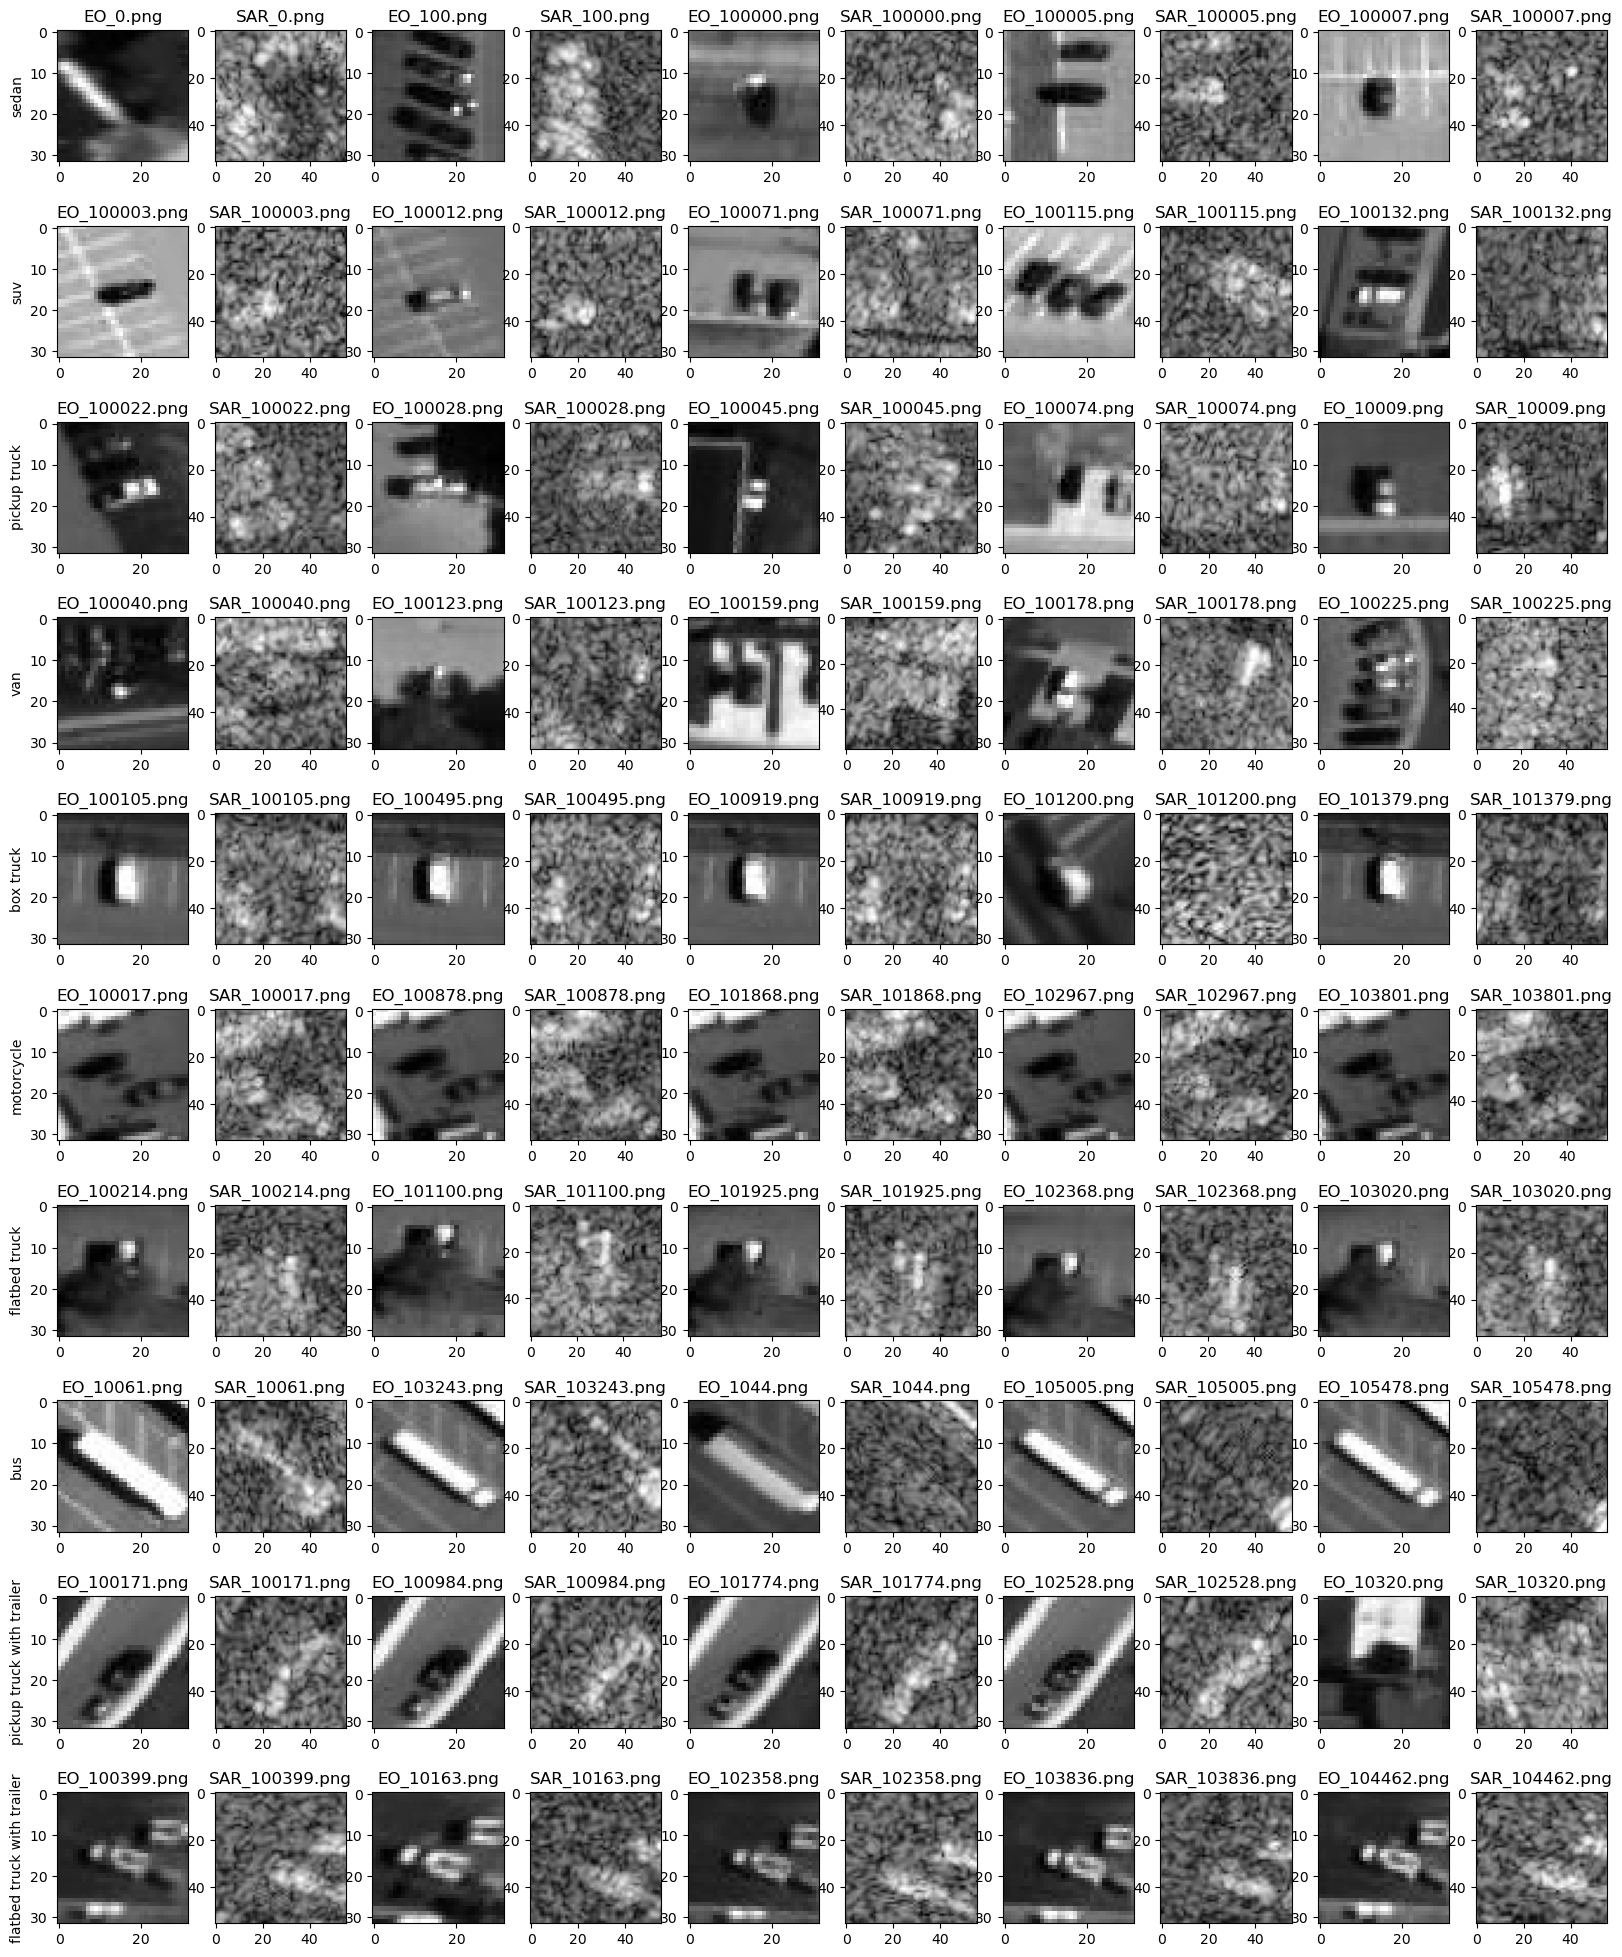

In [62]:
# Open side-by-side the first 5 images for EO and SAR images for all labels

fig, ax = plt.subplots(10, 10, figsize=(20,25))

# For all labels
for i in range(10):
    # For a sample of 5 images
    for j in range(0,10,2):
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][j] 
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Displaying the images
        ax[i][j].imshow(img_eo, cmap='gray')
        ax[i][j].set_title(eo_filenames[i][j])
        ax[i][j+1].imshow(img_sar, cmap='gray')
        ax[i][j+1].set_title(sar_filenames[i][j])
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()

# Data Exploration

In [3]:
# Checks that all EO and SAR images are represented in training set 

rootdir = './train_images'
total_eo_files = 0
total_sar_files = 0
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        eo_num_files = len([name for name in os.listdir(d) if os.path.isfile(os.path.join(d, name)) and name.startswith("EO")])
        sar_num_files = len([name for name in os.listdir(d) if os.path.isfile(os.path.join(d, name)) and name.startswith("SAR")])
        print("Directory %s (EO): %d" %(d, eo_num_files))
        print("Directory %s (SAR): %d" %(d, sar_num_files))
        total_eo_files += eo_num_files
        total_sar_files += sar_num_files
print(total_eo_files)
print(total_sar_files)

Directory ./train_images/9 (EO): 633
Directory ./train_images/9 (SAR): 633
Directory ./train_images/0 (EO): 234209
Directory ./train_images/0 (SAR): 234209
Directory ./train_images/7 (EO): 624
Directory ./train_images/7 (SAR): 624
Directory ./train_images/6 (EO): 828
Directory ./train_images/6 (SAR): 828
Directory ./train_images/1 (EO): 28089
Directory ./train_images/1 (SAR): 28089
Directory ./train_images/8 (EO): 840
Directory ./train_images/8 (SAR): 840
Directory ./train_images/4 (EO): 1741
Directory ./train_images/4 (SAR): 1741
Directory ./train_images/3 (EO): 10655
Directory ./train_images/3 (SAR): 10655
Directory ./train_images/2 (EO): 15301
Directory ./train_images/2 (SAR): 15301
Directory ./train_images/5 (EO): 852
Directory ./train_images/5 (SAR): 852
293772
293772


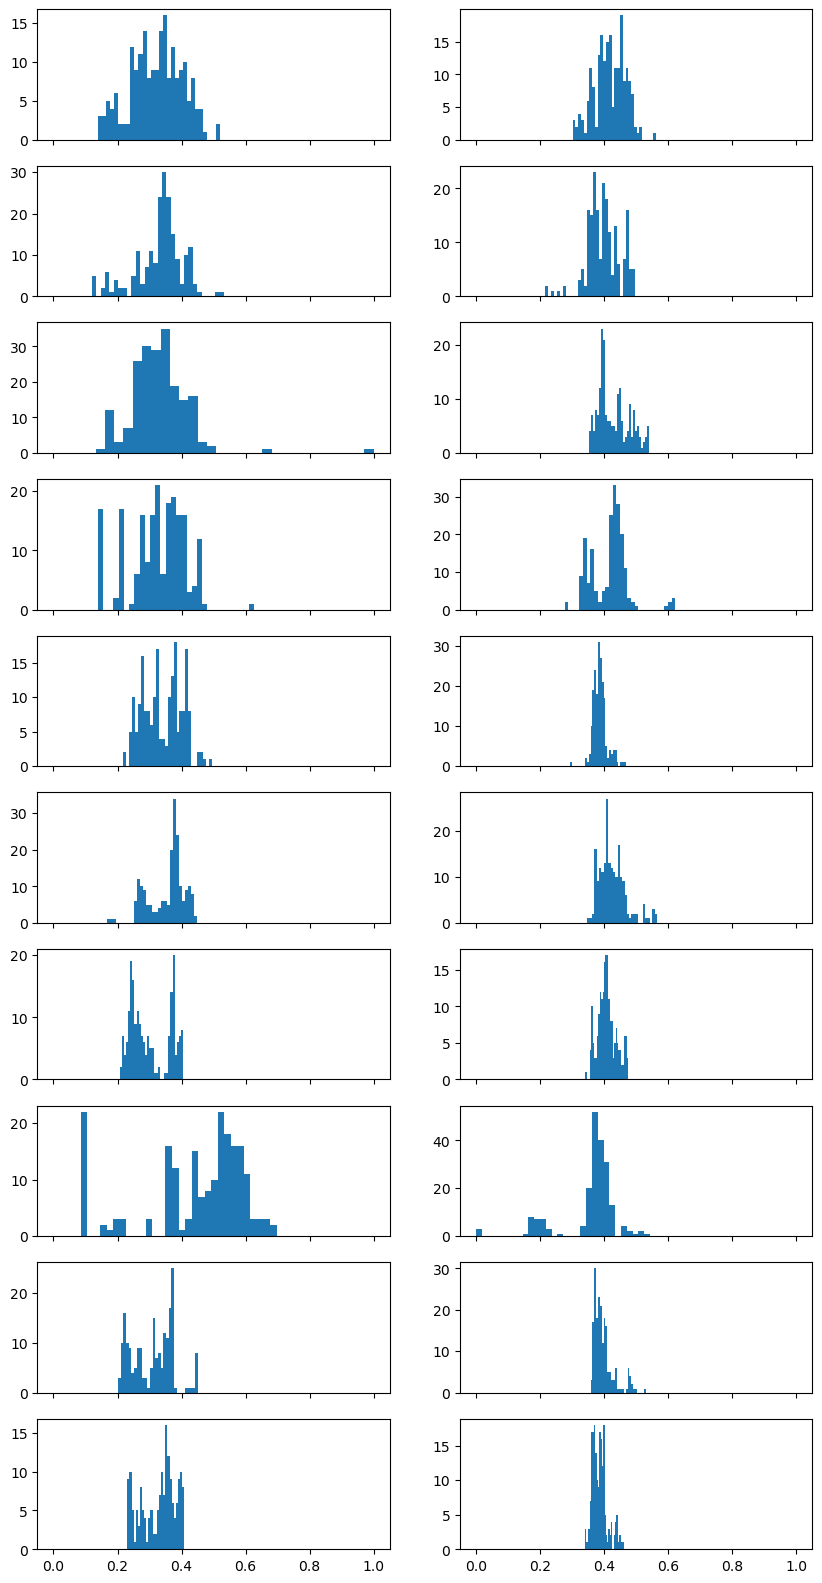

In [156]:
# Checks overall mean signal levels for first 100 images for each image across labels
num_images = 200

mean_eo_signals = np.zeros((10,num_images))
mean_sar_signals = np.zeros((10,num_images))

for i in range(10): # For all labels
    for j in range(num_images): # 
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][j] 
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Get mean for the image
        mean_eo_signals[i,j] = np.mean(img_eo)
        mean_sar_signals[i,j] = np.mean(img_sar)

# Plot distribution of mean signals for 200 images of each label
fig, ax = plt.subplots(10, 2, figsize=(10,20), sharex=True)

for i in range(10):
    ax[i][0].hist(mean_eo_signals[i], bins=30)
    ax[i][1].hist(mean_sar_signals[i], bins=30)
        
plt.show()

# Feature Extraction

## Create Gaussian Filters

In [79]:
from scipy import signal
import numpy as np

""" create a 2-D gaussian blurr filter for a given mean and std """
def create_2d_gaussian(size=9, std=1.5):
    gaussian_1d = signal.gaussian(size,std=std)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    gaussian_2d = gaussian_2d/(gaussian_2d.sum())
    return gaussian_2d


""" normalize teh image between 0 and 1 """
def normalize_img(img):
    normalized = (img - img.min())/(img.max() - img.min())    
    return normalized

In [82]:
# create a function that takes in an two images,  
# uses the create_2d_gaussian method inside the utils script to create a 2D Gaussian filter
# then passes these filters to scipy.ndimage's convolve function
# finally, uses these blurred images to return a hybrid image

def hp_filter(im, size=15, std=7):
    # Create filters
    lp = create_2d_gaussian(size=size, std=std)
    imp = np.zeros((size,size))
    imp[int(size/2),int(size/2)] = 1
    hp = imp - lp
    
    # Convolve im2 with high pass filter
    out = convolve(im, hp)
    
    return out

def lp_filter(im, size=15, std=7):
    # Create filters
    lp = create_2d_gaussian(size=size, std=std)
    imp = np.zeros((size,size))
    imp[int(size/2),int(size/2)] = 1
    hp = imp - lp
    
    # Convolve images with filters
    # Convolve im1 with low pass filter
    out = convolve(im, lp)
    
    return out

## Noise Reduction (particularly on SAR)
1. Low Pass Filtering

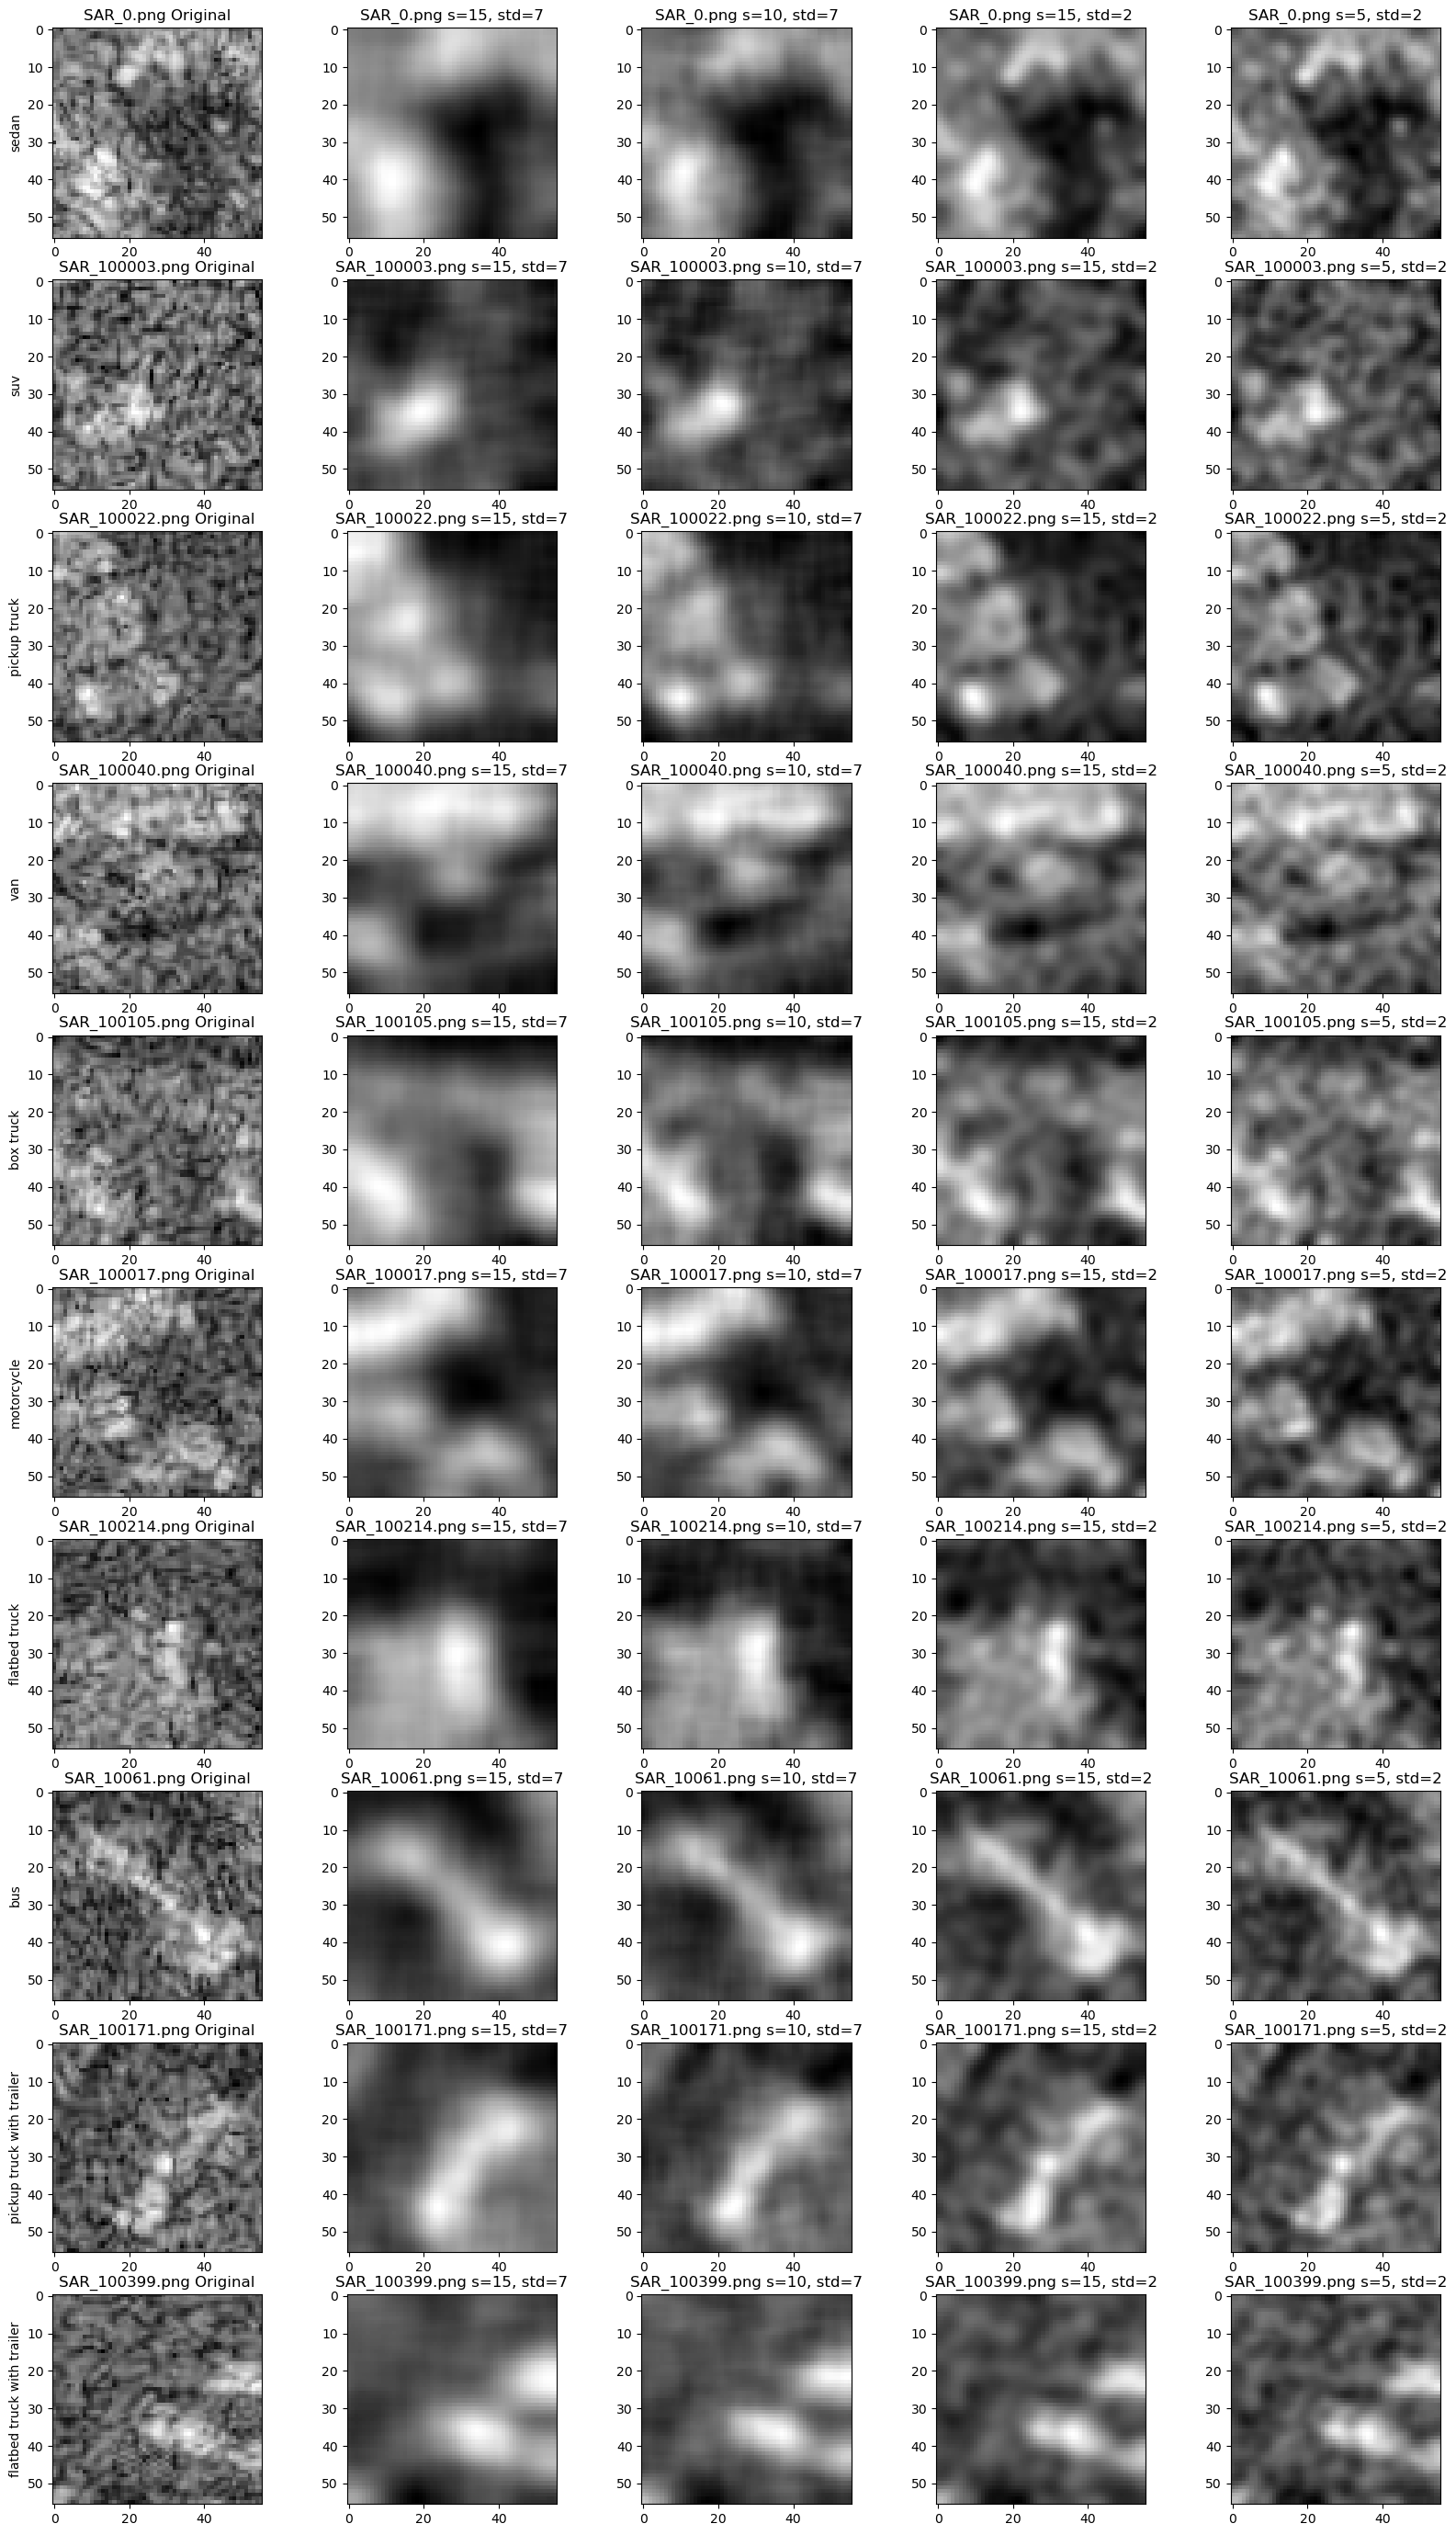

In [99]:
# Noise Reduce SAR Images by LP Filtering

s = 1
fig, ax = plt.subplots(10, s*5, figsize=(20,35))

for i in range(10):
    # For a sample of s images
    for j in range(0,s*5,5):
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][j] 
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        img_sar_lp1 = lp_filter(img_sar, size=15, std=7)
        img_sar_lp2 = lp_filter(img_sar, size=10, std=7)
        img_sar_lp3 = lp_filter(img_sar, size=15, std=2)
        img_sar_lp4 = lp_filter(img_sar, size=5, std=2)
        
        # Displaying the images
        ax[i][j].imshow(img_sar, cmap='gray')
        ax[i][j].set_title(sar_filenames[i][j] + " Original")
        ax[i][j+1].imshow(img_sar_lp1, cmap='gray')
        ax[i][j+1].set_title(sar_filenames[i][j] + " s=15, std=7")
        ax[i][j+2].imshow(img_sar_lp2, cmap='gray')
        ax[i][j+2].set_title(sar_filenames[i][j] + " s=10, std=7")
        ax[i][j+3].imshow(img_sar_lp3, cmap='gray')
        ax[i][j+3].set_title(sar_filenames[i][j] + " s=15, std=2")
        ax[i][j+4].imshow(img_sar_lp4, cmap='gray')
        ax[i][j+4].set_title(sar_filenames[i][j] + " s=5, std=2")
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()

## Sharpening (on EO first)

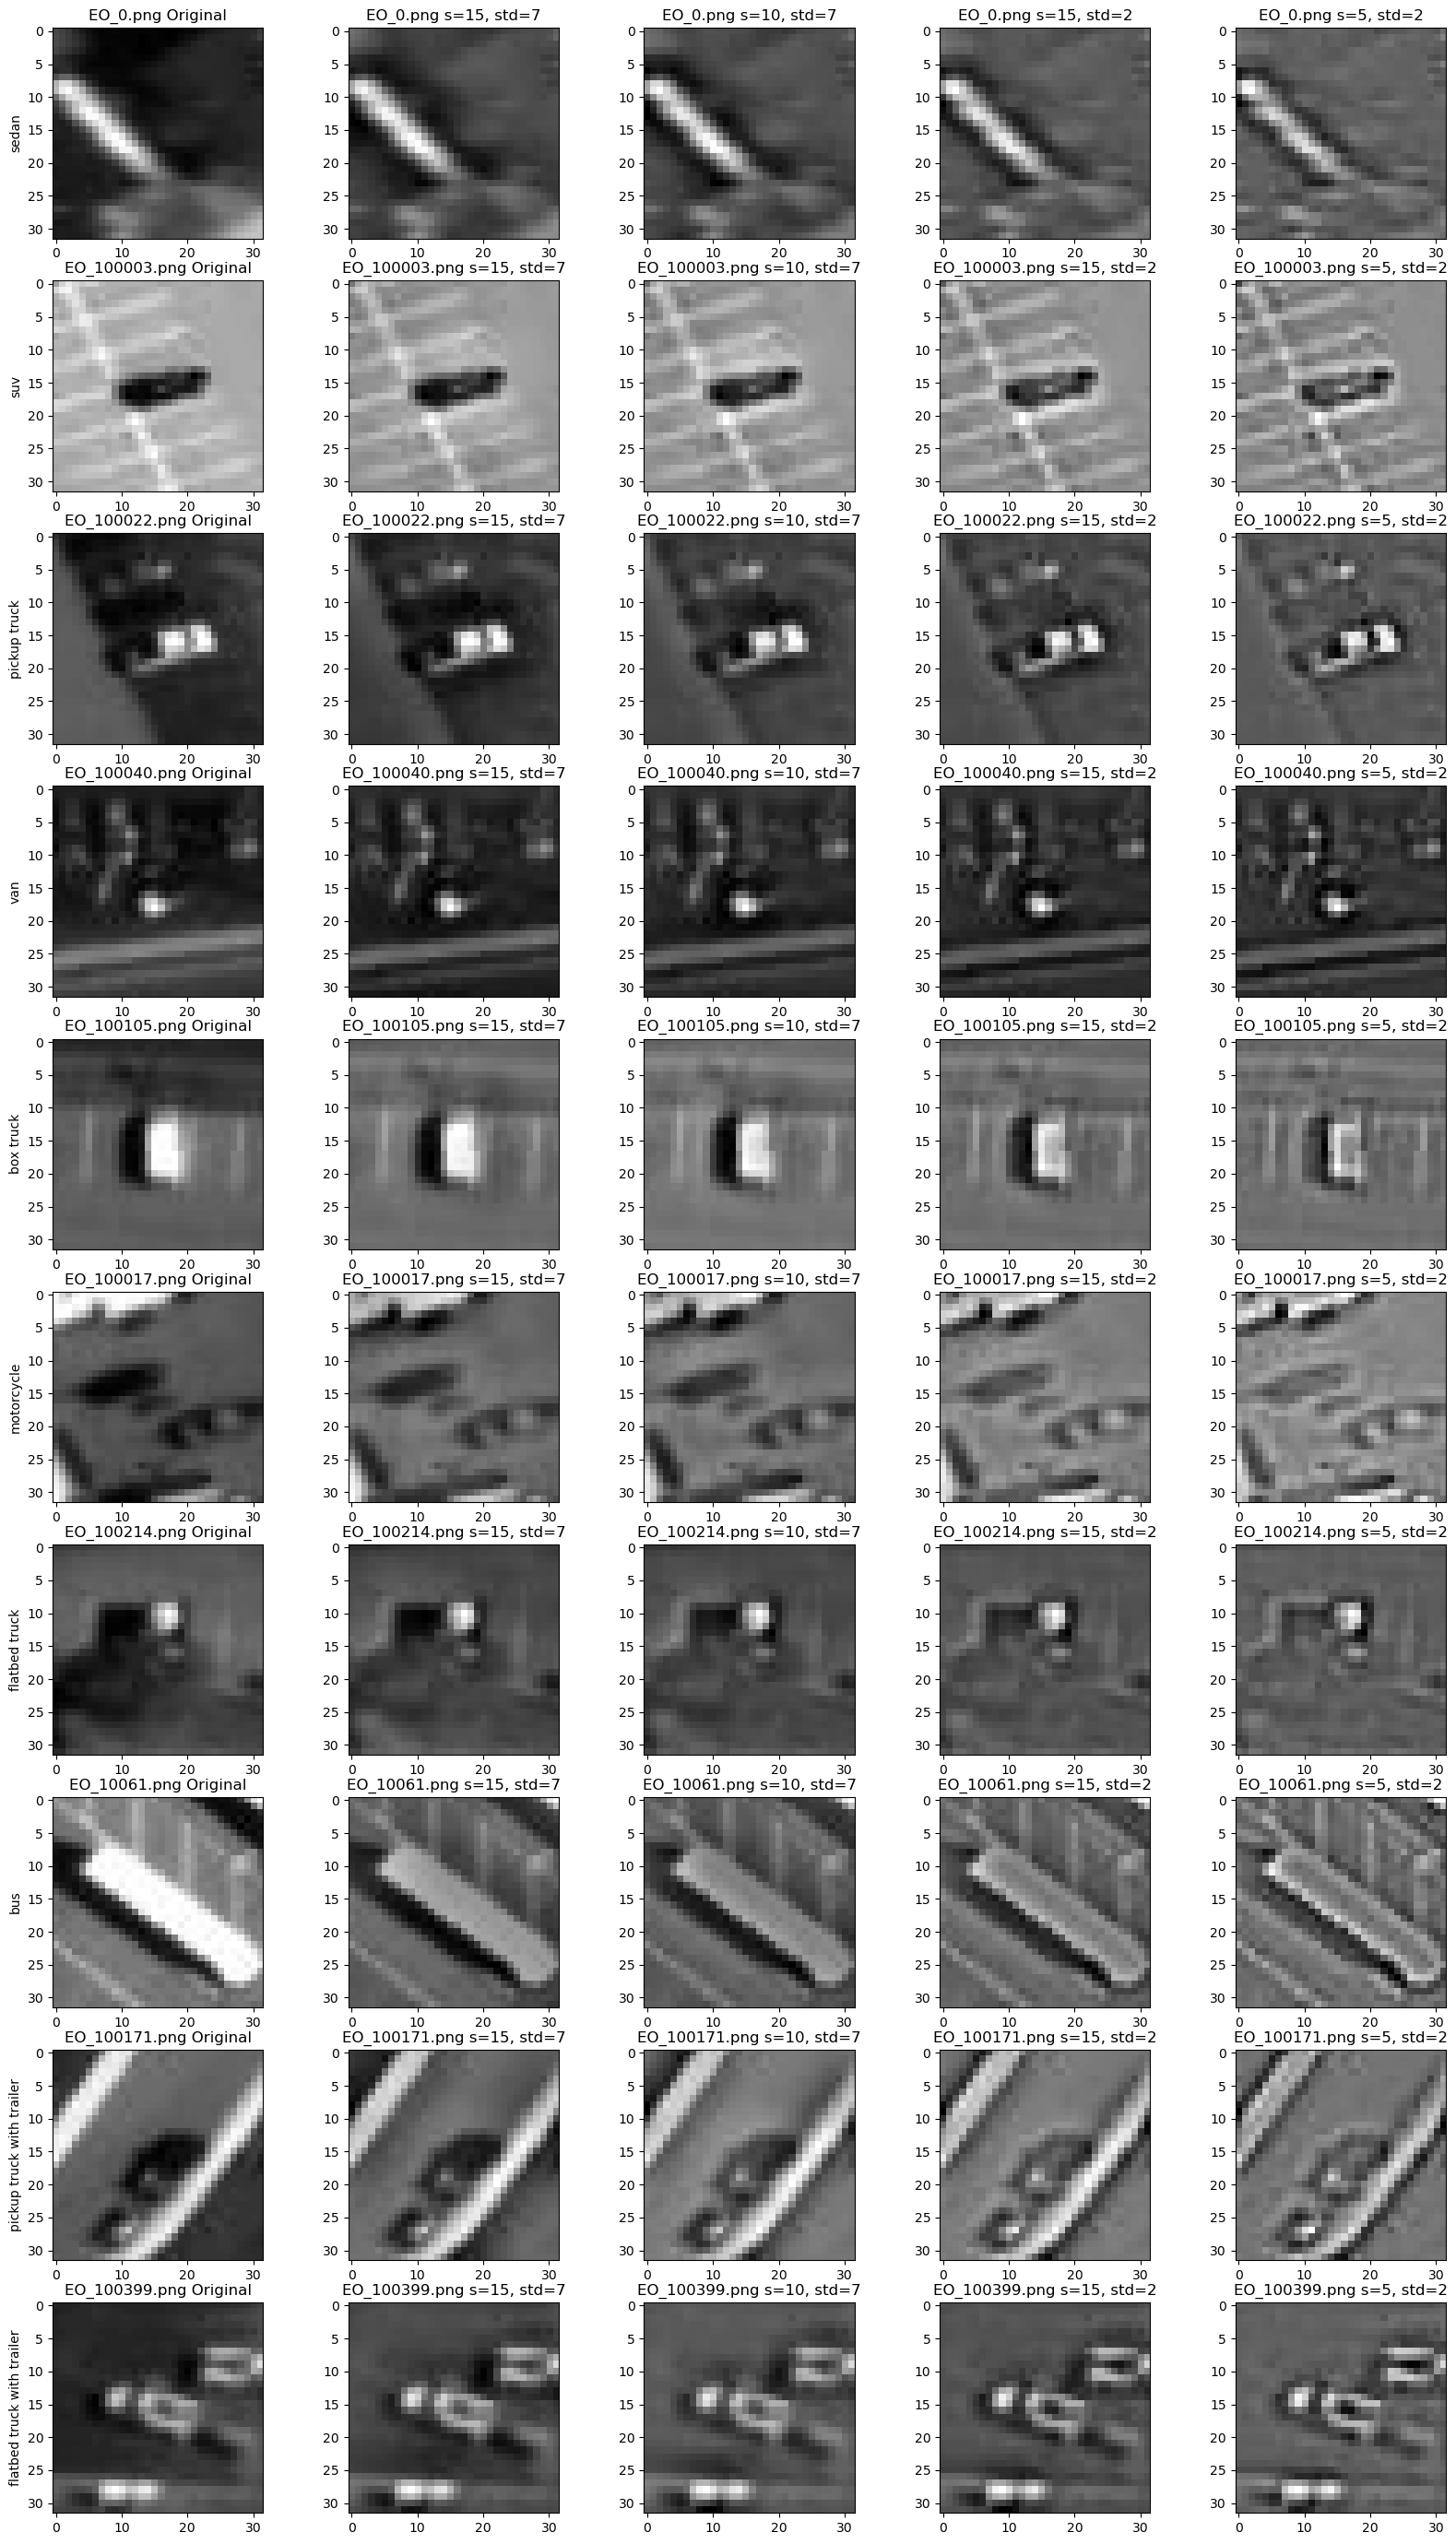

In [97]:
# Sharpen EO Images by HP Filtering

s = 1
fig, ax = plt.subplots(10, s*5, figsize=(20,35))

for i in range(10):
    # For a sample of s images
    for j in range(0,s*5,5):
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][j] 
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        img_eo_hp1 = hp_filter(img_eo, size=15, std=7)
        img_eo_hp2 = hp_filter(img_eo, size=10, std=7)
        img_eo_hp3 = hp_filter(img_eo, size=15, std=2)
        img_eo_hp4 = hp_filter(img_eo, size=5, std=2)
        
        # Displaying the images
        ax[i][j].imshow(img_eo, cmap='gray')
        ax[i][j].set_title(eo_filenames[i][j] + " Original")
        ax[i][j+1].imshow(img_eo_hp1, cmap='gray')
        ax[i][j+1].set_title(eo_filenames[i][j] + " s=15, std=7")
        ax[i][j+2].imshow(img_eo_hp2, cmap='gray')
        ax[i][j+2].set_title(eo_filenames[i][j] + " s=10, std=7")
        ax[i][j+3].imshow(img_eo_hp3, cmap='gray')
        ax[i][j+3].set_title(eo_filenames[i][j] + " s=15, std=2")
        ax[i][j+4].imshow(img_eo_hp4, cmap='gray')
        ax[i][j+4].set_title(eo_filenames[i][j] + " s=5, std=2")
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()

## Unsharp mask filtering on SAR Images

0.0
1.0


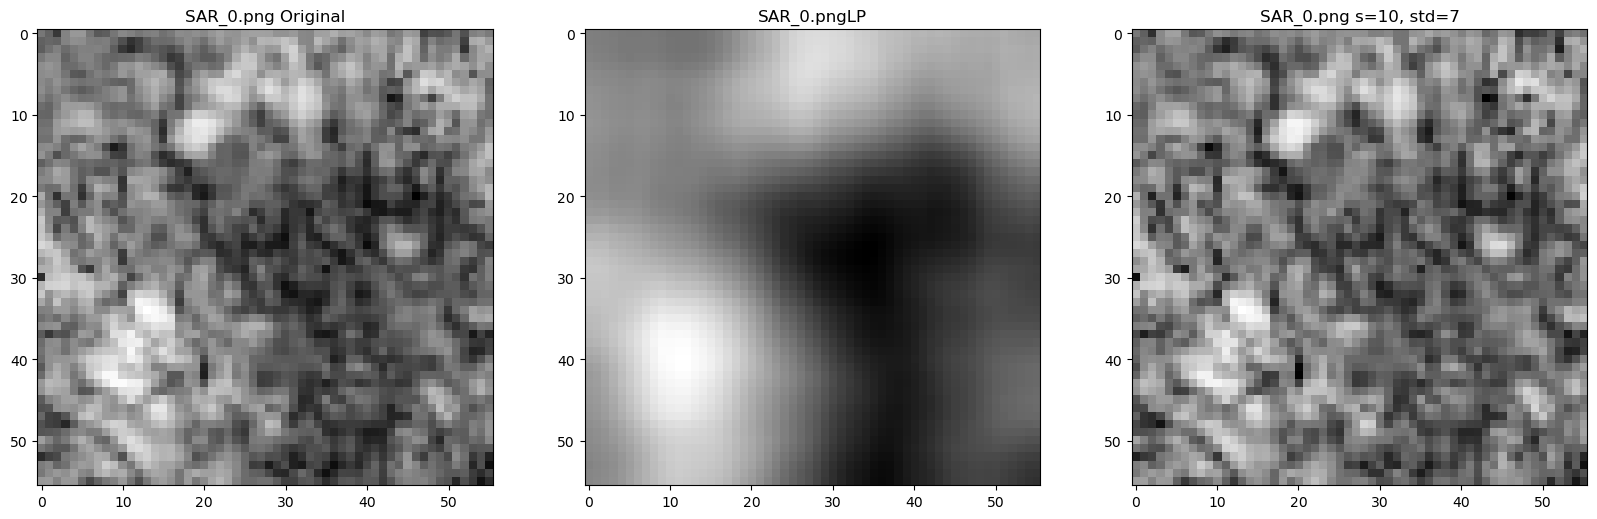

In [111]:
# Subtract the blurred image [Ib] from original image [I], to get the high frequency image: [Ih = I - Ib]. 
# Then add the high frequency image [Ih] back to the original [I] to get the unsharp mask image: [Is = I + Ih]

path_sar = rootdir + "/0/" + sar_filenames[0][0]


# Read images
img_sar = plt.imread(path_sar)

img_sar_lp = lp_filter(img_sar, size=15, std=7)
img_unsharp_mask = (img_sar - img_sar_lp) + img_sar
img_unsharp_mask_norm = normalize_img(img_unsharp_mask)
print(img_unsharp_mask_norm.min())
print(img_unsharp_mask_norm.max())

# Displaying the images
fig, ax = plt.subplots(1, 3, figsize=(20,35))
i = 0
j = 0
ax[j].imshow(img_sar, cmap='gray')
ax[j].set_title(sar_filenames[0][0] + " Original")
ax[j+1].imshow(img_sar_lp, cmap='gray')
ax[j+1].set_title(sar_filenames[0][0] + " LP")
ax[j+2].imshow(img_unsharp_mask_norm, cmap='gray')
ax[j+2].set_title(sar_filenames[0][0] + " s=10, std=7")
# ax[i][j+3].set_title(eo_filenames[i][j] + " s=15, std=2")
# ax[i][j+4].imshow(img_eo_hp4, cmap='gray')
# ax[i][j+4].set_title(eo_filenames[i][j] + " s=5, std=2")
plt.show()

## Edge Detection (after noise reduction for SAR and sharpening for EO)
Methods to employ:
1. Canny edge detector.
2. Directional Derivatives to Gradients
3. Histogram of gradients?



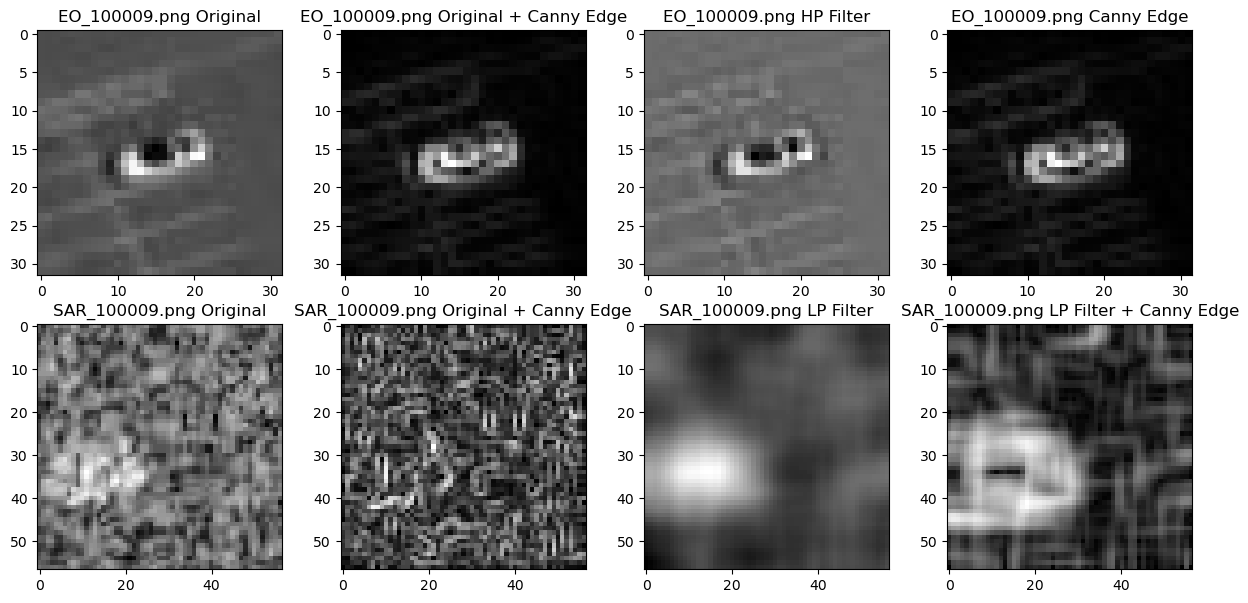

In [175]:
# extract the features from the image
# 
# convert to grayscale
i = 0 # Folder or Label Number
j = 10 # Image Number

path_eo = rootdir + "/" + str(i) + "/"  + eo_filenames[i][j]
path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j]


# Read images
img_eo = plt.imread(path_eo)
img_sar = plt.imread(path_sar)

# Put EO image through HP filter
img_eo_hp = hp_filter(img_eo, size=5, std=2)
# img_eo_hp1 = hp_filter(img_eo, size=15, std=7)
# img_eo_hp2 = hp_filter(img_eo, size=10, std=7)
# img_eo_hp3 = hp_filter(img_eo, size=15, std=2)
# img_eo_hp4 = hp_filter(img_eo, size=5, std=2)
# img_eo_hp = img_eo # use this if don't want to apply filter

# Put SAR image through LP filter
img_sar_lp = lp_filter(img_sar, size=15, std=7)
# img_sar_lp = img_sar # use this if don't want to apply filter

# Normalize images
if np.max(img_eo)>1:
    img_eo = normalize(img_eo)
    
if np.max(img_sar_lp)>1:
    img_sar_lp = normalize(img_sar_lp)
    
# Compute edges of the EO image 
# TODO: decide the ksize for extracting the edges
eo_sobelx = cv2.Sobel(img_eo,cv2.CV_32F,1,0, ksize=3) # Find x and y gradients
eo_sobely = cv2.Sobel(img_eo,cv2.CV_32F,0,1, ksize=3)
eo_magnitude = np.sqrt(eo_sobelx**2.0 + eo_sobely**2.0)
eo_magnitude = eo_magnitude/np.max(eo_magnitude) # normalize

# Compute edges of the EO image + HP Filter
# TODO: decide the ksize for extracting the edges
eo_hp_sobelx = cv2.Sobel(img_eo_hp,cv2.CV_32F,1,0, ksize=3) # Find x and y gradients
eo_hp_sobely = cv2.Sobel(img_eo_hp,cv2.CV_32F,0,1, ksize=3)
eo_hp_magnitude = np.sqrt(eo_hp_sobelx**2.0 + eo_hp_sobely**2.0)
eo_hp_magnitude = eo_hp_magnitude/np.max(eo_hp_magnitude) # normalize
    
# Compute edges of the SAR image 
# TODO: decide the ksize for extracting the edges
sar_sobelx = cv2.Sobel(img_sar,cv2.CV_32F,1,0, ksize=3) # Find x and y gradients
sar_sobely = cv2.Sobel(img_sar,cv2.CV_32F,0,1, ksize=3)
sar_magnitude = np.sqrt(sar_sobelx**2.0 + sar_sobely**2.0)
sar_magnitude = sar_magnitude/np.max(sar_magnitude) # normalize

# Compute edges of the SAR image + LP Filter
# TODO: decide the ksize for extracting the edges
sar_lp_sobelx = cv2.Sobel(img_sar_lp,cv2.CV_32F,1,0, ksize=3) # Find x and y gradients
sar_lp_sobely = cv2.Sobel(img_sar_lp,cv2.CV_32F,0,1, ksize=3)
sar_lp_magnitude = np.sqrt(sar_lp_sobelx**2.0 + sar_lp_sobely**2.0)
sar_lp_magnitude = sar_lp_magnitude/np.max(sar_lp_magnitude) # normalize


# Display Plots
# EO
fig, ax = plt.subplots(2, 4, figsize=(15,7))
ax[0][0].imshow(img_eo, cmap='gray')
ax[0][0].set_title(eo_filenames[i][j] + " Original")
ax[0][1].imshow(eo_magnitude, cmap='gray')
ax[0][1].set_title(eo_filenames[i][j] + " Original + Canny Edge")
ax[0][2].imshow(img_eo_hp, cmap='gray')
ax[0][2].set_title(eo_filenames[i][j] + " HP Filter")
ax[0][3].imshow(eo_magnitude, cmap='gray')
ax[0][3].set_title(eo_filenames[i][j] + " Canny Edge")
# SAR
ax[1][0].imshow(img_sar, cmap='gray')
ax[1][0].set_title(sar_filenames[i][j] + " Original")
ax[1][1].imshow(sar_magnitude, cmap='gray')
ax[1][1].set_title(sar_filenames[i][j] + " Original + Canny Edge")
ax[1][2].imshow(img_sar_lp, cmap='gray')
ax[1][2].set_title(sar_filenames[i][j] + " LP Filter")
ax[1][3].imshow(sar_lp_magnitude, cmap='gray')
ax[1][3].set_title(sar_filenames[i][j] + " LP Filter + Canny Edge")


# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im_ax, cax=cax)
plt.show()


# Label #5 appears to have a lot of the same scene, just taken immediately after each other. Is that going to cause an issue?